#  Water Quality & Potability Prediction: Phase ML Lab

Bu notebook, suyun kimyasal özelliklerine (pH, Sertlik, Sülfat vb.) bakarak insan tüketimi için güvenli olup olmadığını (Potability) tahmin etmeyi amaçlar. Bu proje kapsamında "Klasik Makine Öğrenmesi (Faz 1)" yeteneklerimizi sergileyeceğiz.

##  What Will We Do In This Notebook?
1. **İleri Seviye EDA:** Verideki gizli desenleri görselleştirme.
2. **Missing Value Imputation:** Eksik sensör verilerini (özellikle pH ve Sülfat) doldurma stratejileri.
3. **Feature Scaling:** Birbirinden çok farklı aralıklardaki kimyasal ölçümleri standartlaştırma (`StandardScaler`).
4. **Klasik Modeller (Faz 1):** Lojistik Regresyon, Destek Vektör Makineleri (SVM) ve KNN ile sınıflandırma.

In [3]:
# Basic Data Manipulation and Visualization 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Skearn Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # Eksik verileri doldurmak için başrol oyuncumuz
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Stop Warnings 
import warnings
warnings.filterwarnings('ignore')

# Data Reading 

df = pd.read_csv('/kaggle/input/datasets/nayanack/water-probability/water_potability.csv')

# First Look
display(df.head())

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## Check-Up

--- Dataset Sum ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None
--- NULL Data Numbers ---
ph                 491
Sulfate            781
Trihalomethanes    162
dtype: int64


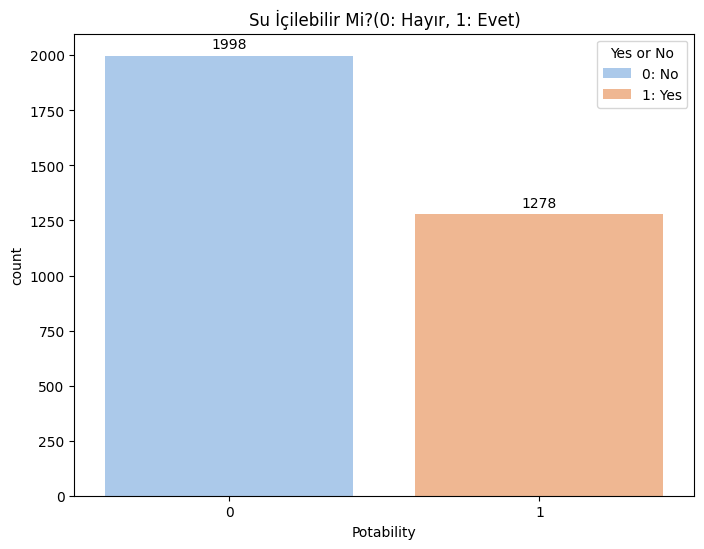

In [4]:
# DataSet Information 
print("--- Dataset Sum ---")
print(df.info())

# How Many Value Are None?
print("--- NULL Data Numbers ---")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

# Is Potability?
plt.figure(figsize=(8,6))
ax = sns.countplot(data=df, x='Potability', palette = 'pastel')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)
plt.title("Su İçilebilir Mi?(0: Hayır, 1: Evet)")
plt.legend(title="Yes or No", labels = ['0: No', '1: Yes'])
plt.show()

In [7]:
# Smart Imputation
# Sütunlardaki hedef değişken olan 'Potability'e göre gruplayıp kendi içlerindeki medyan ile dolduruyoruz
# Medyan kullanma sebebimiz ortalama (mean) uç değerlerden (outliers) çok etkilenir.
features_with_nan = ['ph', 'Sulfate', 'Trihalomethanes']
for feature in features_with_nan:
    df[feature] = df[feature].fillna(df.groupby('Potability')[feature].transform('median'))

print("--- After Cleaning Null Data Status ---")
print(df.isnull().sum())


--- After Cleaning Null Data Status ---
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


## Exploratory Data Analysis (EDA)

We will answer two basic questions 
1. Hangi kimyasal özellikler suyun içilebilirliğini daha çok etkiliyor?
2. Kimyasal Özelliklerin kendi aralarında bir matematiksel ilişkisi (correlation) var mı?

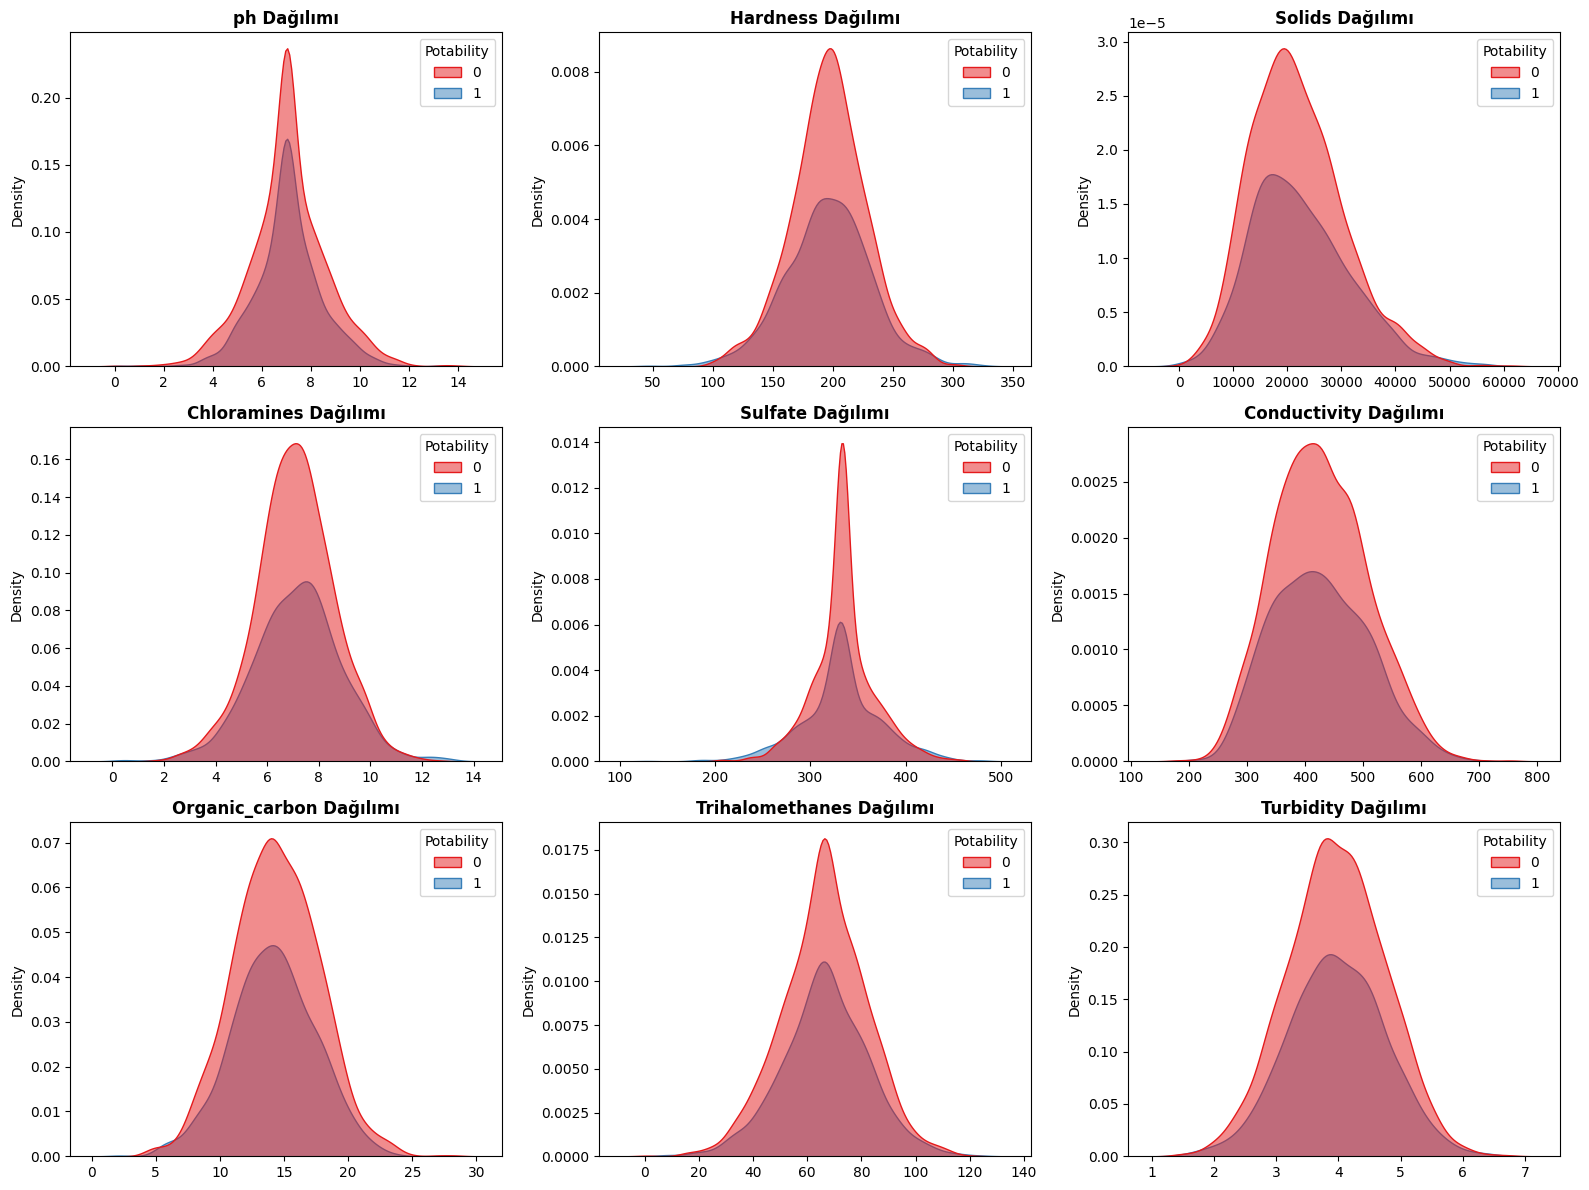

In [8]:
import math

# Potability Out
features = df.columns.drop('Potability')

# 3x3 Gird (9 Graphs)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten() # 2x2 Matrix -> 1D (Döngüde kolaylık olsun diye)

# Each features KDE Graphics
for i,col in enumerate(features):
    sns.kdeplot(
        data=df,
        x=col,
        hue='Potability',
        fill=True,
        ax=axes[i],
        palette='Set1',
        alpha=0.5
    )
    axes[i].set_title(f'{col} Dağılımı', fontsize = 12, fontweight='bold')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()



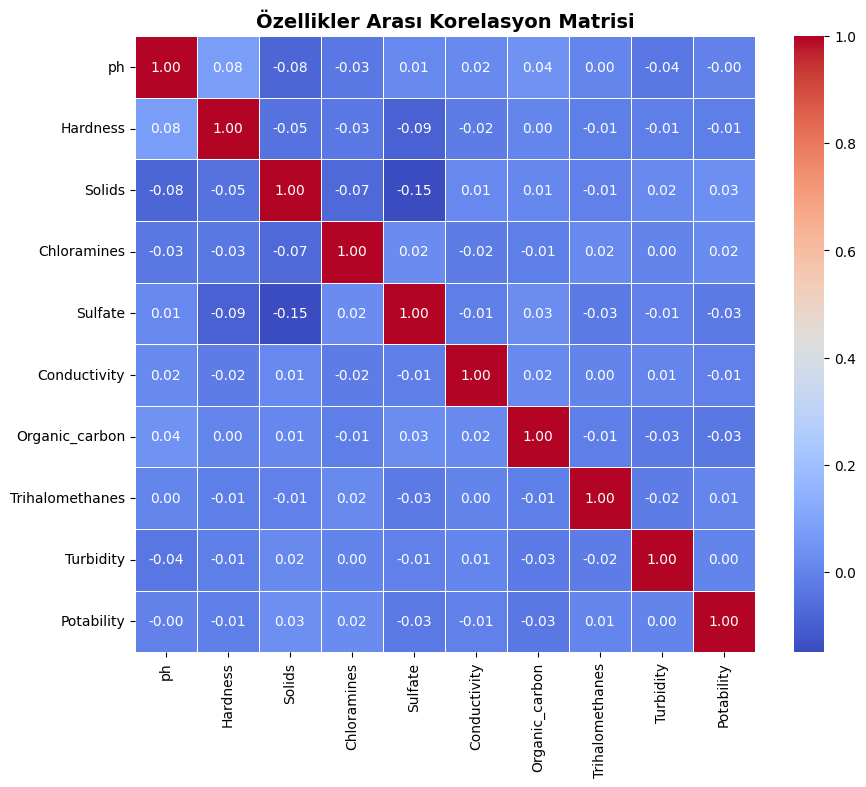

In [9]:
plt.figure(figsize=(10, 8))

#df.corr() will give correlation factor (-1 to 1)
sns.heatmap(
    df.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidth=0.5
)
plt.title("Özellikler Arası Korelasyon Matrisi", fontsize=14, fontweight='bold')
plt.show()

##  EDA Insights

1. **Özellik Dağılımları (KDE Plots):** İçilebilir (1) ve İçilemez (0) suların dağılım eğrileri hemen hemen tüm özelliklerde **tamamen üst üste biniyor**. 
   * *Bunun Anlamı:* Suyu sınıflandırmak için "Sadece pH'a bakalım" veya "Sadece Sertliğe bakalım" diyemeyiz. Tek başına hiçbir özellik sihirli bir ayrım gücüne sahip değil.
2. **Korelasyon Eksikliği:** Özelliklerin birbirleriyle ve muhtemelen hedef değişkenle doğrusal (lineer) bir ilişkisi yok. Çoğu değer 0.01 civarında. (Sadece Sulfate ve Solids arasında zayıf bir -0.15 ilişkisi var).
   * *Model Seçimine Etkisi:* Doğrusal ilişkilerin olmaması ve iç içe geçmiş veriler, **Lojistik Regresyon** gibi basit doğrusal modellerin bu veri setinde çok zorlanacağını (hatta çuvallayacağını) gösteriyor. Sınırları daha esnek çizebilen **KNN** veya non-lineer **SVM** modellerine ihtiyacımız var.

## Models (LR-SVM-KNN)

In [11]:
# X and y
X = df.drop('Potability', axis=1)
y = df['Potability']

# Train and Test Split (%20 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Scaling (StandardScaler) - KNN and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Configuration
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine (RBF)': SVC(kernel='rbf', random_state=42)
}

# Model Train and Test
print("--- Model Performances ---")
for name, model in models.items():
    # Model Fitting
    model.fit(X_train_scaled, y_train)

    # Predicting
    y_pred = model.predict(X_test_scaled)

    # Scores
    print(f"--- {name} Scores ---")
    print(classification_report(y_test, y_pred))
    

--- Model Performances ---
--- Logistic Regression Scores ---
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       412
           1       0.00      0.00      0.00       244

    accuracy                           0.63       656
   macro avg       0.31      0.50      0.39       656
weighted avg       0.39      0.63      0.48       656

--- K-Nearest Neighbors Scores ---
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       412
           1       0.51      0.42      0.46       244

    accuracy                           0.63       656
   macro avg       0.60      0.59      0.59       656
weighted avg       0.62      0.63      0.62       656

--- Support Vector Machine (RBF) Scores ---
              precision    recall  f1-score   support

           0       0.70      0.92      0.79       412
           1       0.70      0.33      0.45       244

    accuracy                           0.

##  Results and Business Insight

Faz 1 modellerini (Klasik ML) eğittikten sonra şu çarpıcı sonuçlara ulaştık:

###  Model Reviews:
* **Logistic Regression (%63 Accuracy):** Sınıflandırma yeteneği tamamen çökmüştür. Veri doğrusal (lineer) olarak ayrılamadığı için model her suyu "0 (İçilemez)" olarak tahmin etme eğilimine girmiştir (Recall for 1: 0.00).
* **KNN (%63 Accuracy):** Doğrusal olmayan sınırları bulmaya çalışmış, İçilebilir suların %42'sini yakalamayı başarmış ancak genel performansı düşük kalmıştır.
* **SVM-RBF (%70 Accuracy - ŞAMPİYON):** Veriyi daha yüksek boyutlara taşıyarak en iyi genel doğruluğa ulaşmıştır. Ancak, veri setindeki dengesizlikten (Imbalance) dolayı azınlık sınıfı olan "İçilebilir (1)" suları yakalamada (Recall: 0.33) yetersiz kalmıştır.

### Why Models Performances are Low?
EDA aşamasında çizdiğimiz Yoğunluk (KDE) grafiklerinde de gördüğümüz üzere, kimyasal özellikler içilebilir ve içilemez sular için **neredeyse tamamen üst üste binmektedir**. Tek başına "Sülfatı yüksekse içilemez" gibi kurallar kurmak imkansızdır.

 **Next Steps:** Bu veri setindeki karmaşık (non-lineer) sınırları ve veri dengesizliğini çözmek için **Faz 3** algoritmalarına (XGBoost, Random Forest) ve Eşik Değeri Optimizasyonuna (Threshold Tuning) ihtiyaç vardır.